Link to Tableau Workbook: https://drive.google.com/file/d/1Udl3guXjLRdEZnUYoWfUkqGuc3lHEh6V/view?usp=sharing

### Import Required Packages

In [1]:
import boto3
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
import os

### Connect to S3

In [2]:
client = boto3.client('s3')

In [3]:
path = 's3://moz-sr-data-analyst/'

In [4]:
s3 = boto3.resource('s3')
my_bucket = s3.Bucket('moz-sr-data-analyst')

for my_bucket_object in my_bucket.objects.all():
    print(my_bucket_object.key)

columns.tsv
industries.csv
website_logins/partition=1/c529fa6a3c1c4f59a479cfe09fef95b1.parquet
website_logins/partition=2/d5cf97a41ef14917994cc133878208de.parquet
website_logins/partition=3/9c84cacb114c4aaa8c781306f4909b95.parquet
website_logins/partition=4/1c03d4bc41964861a1831e033254bd62.parquet
website_logins/partition=5/1d7a393aa9314fd78b6aab06171511f5.parquet
website_logins/partition=6/30655ffceadb43888f353a222399df75.parquet


### Import Data from S3 and Clean the Data

In [5]:
columns = pd.read_csv('s3://moz-sr-data-analyst/columns.tsv', sep = '\t')

In [6]:
columns

,column_name,position
0,id,0
1,industry_key,1
2,geography,2
3,most_common_browser,3
4,session_time_prior_month_seconds,4
5,prior_month_paid,5


In [7]:
industries = pd.read_csv('s3://moz-sr-data-analyst/industries.csv')

In [8]:
industries.T

,0,1,2,3,4,5,6,7,8,9,10
industry,Marketing Agency,NaN,NaN,health care,healthcare,marketing agency,mktg agency,NaN,software,unk,unknown
industry_key,5,9,10,1,2,4,3,11,6,8,7


In [9]:
industries = industries.replace(np.nan, 'Unknown', regex=True)

In [10]:
industries['industry'] = industries['industry'].apply(lambda x: 'Healthcare' if 'care' in x 
                 else('Marketing Agency' if 'agency' in x
                      else('Unknown' if 'unk' in x else x
                      )))

In [11]:
industries.T

,0,1,2,3,4,5,6,7,8,9,10
industry,Marketing Agency,Unknown,Unknown,Healthcare,Healthcare,Marketing Agency,Marketing Agency,Unknown,software,Unknown,Unknown
industry_key,5,9,10,1,2,4,3,11,6,8,7


In [12]:
## case statement pandas to clean industry

In [13]:
website_logins_1 = pq.read_table(source='s3://moz-sr-data-analyst/website_logins/partition=1/c529fa6a3c1c4f59a479cfe09fef95b1.parquet').to_pandas()
website_logins_2 = pq.read_table(source='s3://moz-sr-data-analyst/website_logins/partition=2/d5cf97a41ef14917994cc133878208de.parquet').to_pandas() 
website_logins_3 = pq.read_table(source='s3://moz-sr-data-analyst/website_logins/partition=3/9c84cacb114c4aaa8c781306f4909b95.parquet').to_pandas()
website_logins_4 = pq.read_table(source='s3://moz-sr-data-analyst/website_logins/partition=4/1c03d4bc41964861a1831e033254bd62.parquet').to_pandas()
website_logins_5 = pq.read_table(source='s3://moz-sr-data-analyst/website_logins/partition=5/1d7a393aa9314fd78b6aab06171511f5.parquet').to_pandas()
website_logins_6 = pq.read_table(source='s3://moz-sr-data-analyst/website_logins/partition=6/30655ffceadb43888f353a222399df75.parquet').to_pandas()

In [14]:
website_logins_3.head()

,0,1,2,3,4,5
0,1418200166,2,America,IE,9493.0,128.252010
1,1418200174,8,UK,Chrome,3007.0,32.785887
2,1418200175,11,America,Chrome,NaN,80.574379
3,1418200179,3,US,Chrome,25.0,105.900000
4,1418200185,2,France,Safari,1210.0,47.969101


In [15]:
website_logins = pd.concat([website_logins_1,website_logins_2, website_logins_3,website_logins_4,website_logins_5,website_logins_6] )

In [16]:
website_logins.columns = columns.column_name

In [17]:
website_logins.head()

column_name,id,industry_key,geography,most_common_browser,session_time_prior_month_seconds,prior_month_paid
0,1418200170,1,US,IE,1682.0,105.932246
1,1418200182,4,Canada,Chrome,2824.0,117.570502
2,1418200189,4,Esp,IE,2236.0,77.349066
3,1418200194,2,Esp,Chrome,2480.0,48.719494
4,1418200206,5,United States,Chrome,285.0,113.691472


In [18]:
website_logins.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13014636 entries, 0 to 2167129
Data columns (total 6 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   id                                int64  
 1   industry_key                      object 
 2   geography                         object 
 3   most_common_browser               object 
 4   session_time_prior_month_seconds  float64
 5   prior_month_paid                  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 695.1+ MB


In [19]:
industries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   industry      11 non-null     object
 1   industry_key  11 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 304.0+ bytes


In [20]:
industries = industries.astype({'industry_key': str})

In [21]:
website_logins=website_logins.merge(industries, left_on='industry_key', right_on='industry_key')

In [22]:
website_logins.head()

,id,industry_key,geography,most_common_browser,session_time_prior_month_seconds,prior_month_paid,industry
0,1418200170,1,US,IE,1682.0,105.932246,Healthcare
1,1418200258,1,Greece,Safari,4808.0,57.648758,Healthcare
2,1418200271,1,Canada,Safari,NaN,93.919066,Healthcare
3,1418200295,1,CA,Chrome,3687.0,95.194390,Healthcare
4,1418200376,1,Greece,Safari,1228.0,40.419101,Healthcare


In [23]:
website_logins.head()

,id,industry_key,geography,most_common_browser,session_time_prior_month_seconds,prior_month_paid,industry
0,1418200170,1,US,IE,1682.0,105.932246,Healthcare
1,1418200258,1,Greece,Safari,4808.0,57.648758,Healthcare
2,1418200271,1,Canada,Safari,NaN,93.919066,Healthcare
3,1418200295,1,CA,Chrome,3687.0,95.194390,Healthcare
4,1418200376,1,Greece,Safari,1228.0,40.419101,Healthcare


In [24]:
website_logins.groupby('geography').count()

,id,industry_key,most_common_browser,session_time_prior_month_seconds,prior_month_paid,industry
geography,,,,,,
America,1157894,1157894,1157894,1123230,1157894,1157894
CA,1446411,1446411,1446411,1402753,1446411,1446411
Canada,1446297,1446297,1446297,1402485,1446297,1446297
England,289222,289222,289222,280747,289222,289222
Esp,482938,482938,482938,468525,482938,482938
France,482339,482339,482339,467890,482339,482339
GB,289559,289559,289559,280869,289559,289559
Greece,482340,482340,482340,467785,482340,482340
India,482437,482437,482437,467875,482437,482437


In [25]:
website_logins['geography'] = website_logins['geography'].apply(lambda x: 'United States' if x in ('US', 'USA', 'United States', 'America')
                                 else('Canada' if x in ('CA', 'Canada')
                                      else('United Kingdom' if x in ('GB', 'UK', 'United Kingdom', 'England')
                                          else ('Spain' if x in ('Esp', 'Spain')
                                               else x
                                               ))))

In [26]:
website_logins['prior_month_paid'].min()

-32768.0

In [27]:
website_logins[website_logins['prior_month_paid'] > -32768]['prior_month_paid'].min()

0.01

In [28]:
website_logins[website_logins['prior_month_paid'] == -32768.0].groupby('industry_key').count()

,id,geography,most_common_browser,session_time_prior_month_seconds,prior_month_paid,industry
industry_key,,,,,,
1,16072,16072,16072,16072,16072,16072
10,6345,6345,6345,6345,6345,6345
11,6455,6455,6455,6455,6455,6455
2,16418,16418,16418,16418,16418,16418
3,16095,16095,16095,16095,16095,16095
4,16096,16096,16096,16096,16096,16096
5,16316,16316,16316,16316,16316,16316
6,16271,16271,16271,16271,16271,16271
7,6561,6561,6561,6561,6561,6561


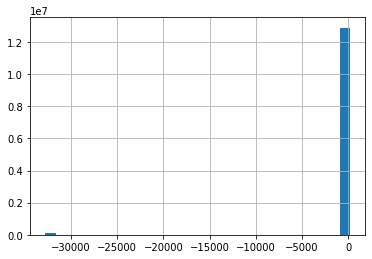

In [29]:
website_logins['prior_month_paid'].hist(bins = 30)

In [30]:
website_logins = website_logins[website_logins['prior_month_paid'] > 0]

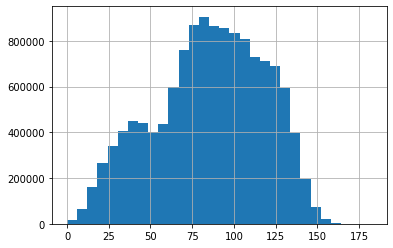

In [31]:
website_logins['prior_month_paid'].hist(bins = 30)

In [32]:
website_logins['session_time_prior_month_seconds'].max()

235003.0

In [33]:
website_logins[website_logins['session_time_prior_month_seconds'] ==235003.0]

,id,industry_key,geography,most_common_browser,session_time_prior_month_seconds,prior_month_paid,industry
4836408,1429139583,2,Canada,Safari,235003.0,141.228741,Healthcare


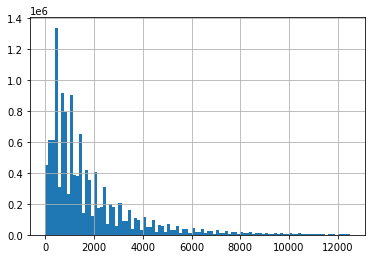

In [34]:
website_logins[website_logins['session_time_prior_month_seconds'] < 12500]['session_time_prior_month_seconds'].hist(bins=100)

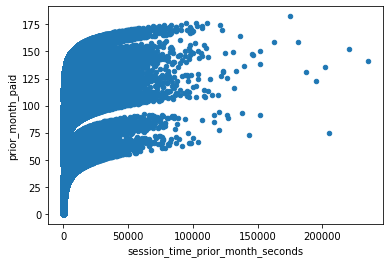

In [35]:
website_logins.plot.scatter(x='session_time_prior_month_seconds',
                            y='prior_month_paid')

### Export Data as CSV file

In [36]:
cwd = os.getcwd()

In [37]:
website_logins.to_csv(os.path.join(cwd, "website_logins.csv"))

#### Data Cleaning Done

- Combining the all the login data into one filem, and adding the column names. Joining to the industries table to get the industry name from the key
- Cleaning country names and industry names to reduce duplication of categories based on variation resulting from data collection 
- Limited data set to where prior month paid was > 0. The amounts less than 0 could be data collection errors, or perhaps some kind of credit given to users but making the assumption that it's okay to exclude these rows out for the purpose of this analysis

#### What information about a user seems to be informative about how much they paid in the prior month?

- The industry and region where a user is located seems to be most correlation with how much a user paid in the previous month

#### Which segment of customers should Moz target for marketing?

- There is an opportunity to acquire more users in the software industry. The users in this group are very profitable in terms of amount paid per user and also make up the smallest number of users in this data set. 
- Acquire more users in the marketing agency space if not already oversaturated 

#### What would your recommended next steps for the business be?

- In addition to acquiring more users in the existing categoriesm there's also an opportunity to test pricing changes for existing categories and countries, for example increasing the cost per second/user in the software and healthcare industry

#### As an analyst, is there additional data you would recommend collecting about these users?

- There is a lot of missing industry data. Would suggest collecting more comprehensive data as there is a high correlation between industry and how much a user pays. 
- Additionally would recommend collecting sub-category at the industry or regional data if available to see if the correlations are higher for one particular area. 
- Might be interesting to look at user role/department given the high correlation between amount paid and industry